In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)
import shutil
shutil.copytree(path, 'data')

100%|██████████| 346M/346M [00:02<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


'data'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
from google.colab import files

In [ ]:

train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'

# Data generators with augmentation for train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For evaluation
)

class_labels = list(train_generator.class_indices.keys())
print(f"Classes: {class_labels}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:



from keras.models import Model
trainable_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers initially
trainable_model.trainable = False

output_layer = trainable_model.layers[-1]

x = Flatten()(output_layer.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=trainable_model.input, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-495562172.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  trainable_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 18,775,366 (71.62 MB)

 Trainable params: 16,517,382 (63.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 335ms/step - accuracy: 0.6676 - loss: 2.8420 - val_accuracy: 0.8285 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.7859 - loss: 0.6564 - val_accuracy: 0.8199 - val_loss: 0.4850 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.7816 - loss: 0.6271 - val_accuracy: 0.8655 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 251ms/step - accuracy: 0.8001 - loss: 0.5795 - val_accuracy: 0.8602 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.8171 - loss: 0.5551 - val_accuracy: 0.8556 - val_loss: 0.4312 - learning_rate: 0.0010
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8209 - loss: 0.5538 - val_accuracy: 0.8641 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.

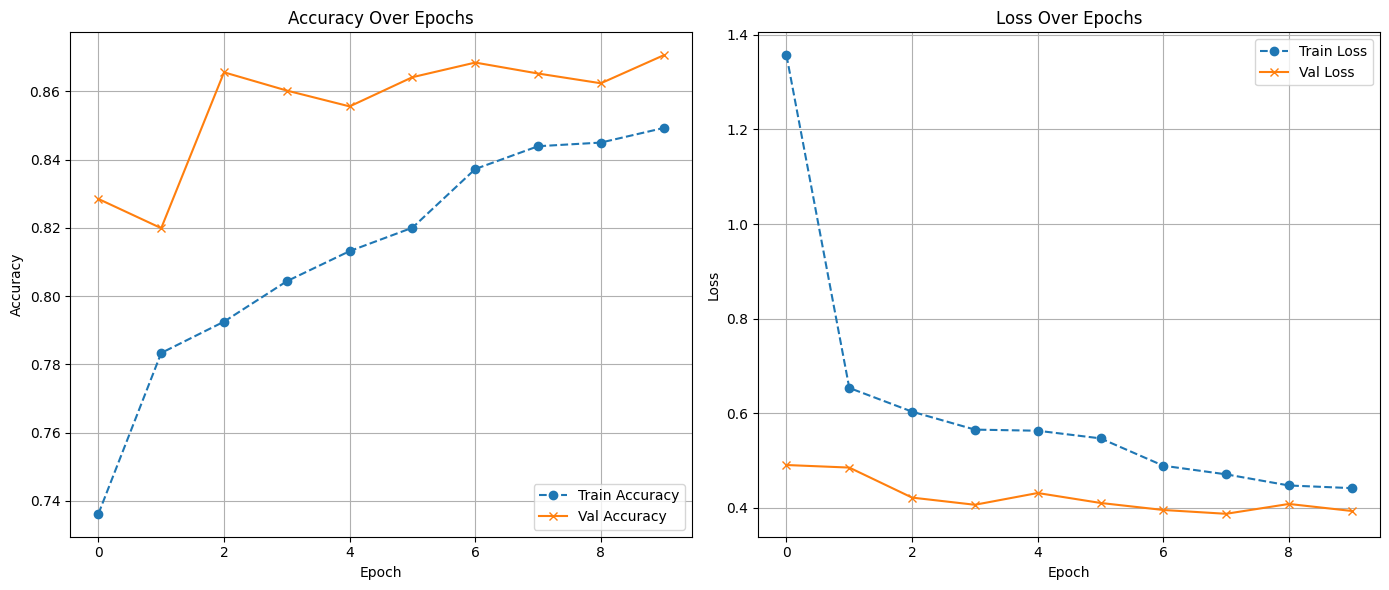

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train with more epochs, using callbacks
history = model.fit(
    train_generator,
    epochs=10,  # Increased for better training; early stopping will halt if needed
    validation_data=val_generator,
    callbacks=callbacks
)

# Enhanced plotting: Include learning rate if available, and use smoother lines
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='-', marker='x')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='-', marker='x')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation Results

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9121 - loss: 0.2469
Test Loss: 0.3174
Test Accuracy: 88.70%
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step

Classification Report:


,precision,recall,f1-score,support
buildings,0.8196,0.9359,0.8739,437.000
forest,0.9914,0.9726,0.9819,474.000
glacier,0.8689,0.8029,0.8346,553.000
mountain,0.7951,0.8571,0.8249,525.000
sea,0.9457,0.9216,0.9335,510.000
street,0.9242,0.8523,0.8868,501.000
accuracy,0.8870,0.8870,0.8870,0.887
macro avg,0.8908,0.8904,0.8893,3000.000
weighted avg,0.8904,0.8870,0.8874,3000.000


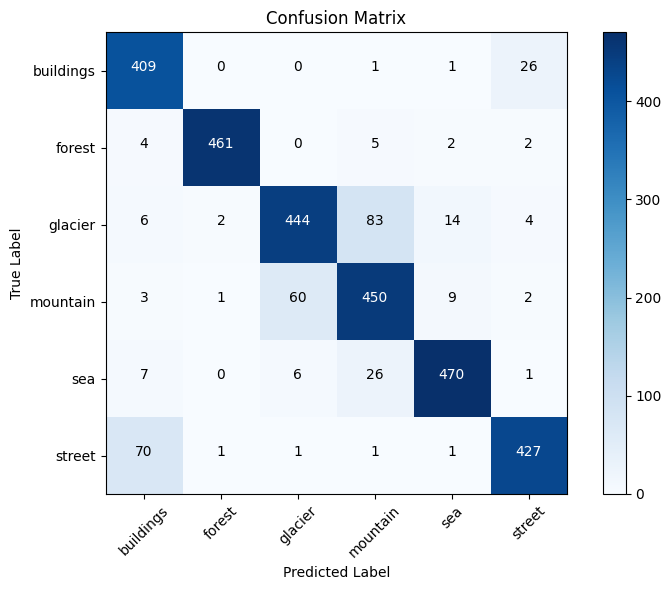


Confusion Matrix Table:


,buildings,forest,glacier,mountain,sea,street
buildings,409,0,0,1,1,26
forest,4,461,0,5,2,2
glacier,6,2,444,83,14,4
mountain,3,1,60,450,9,2
sea,7,0,6,26,470,1
street,70,1,1,1,1,427


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report as a dictionary
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(report_dict).transpose().round(4)

# Display the metrics table (precision, recall, f1-score, support)
print("\nClassification Report:")
display(metrics_df)  # Use display() in Jupyter for nice HTML table output

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Optionally, display confusion matrix as a table
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
print("\nConfusion Matrix Table:")
display(cm_df)

In [ ]:
model.save('intel_scene_classifier.h5')